In [27]:
# Import Neccessary Libraries:

import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm
import pickle
from torch.optim.lr_scheduler import StepLR
import time
from PIL import Image
from torchsummary import summary
import time

In [28]:
# To mount drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
# Checking GPU:
print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [31]:
def get_data_from_drive(copy = True, extract = True):
  start = time.time()
  if copy:
    print("Copying Train Source from Drive.")
    !cp "/content/drive/MyDrive/DS5500 Data/nasa_tropical_storm_competition_train_source.tar" -r "/content/nasa_tropical_storm_competition_train_source.tar"
    print("Copying Test Source from Drive.")
    !cp "/content/drive/MyDrive/DS5500 Data/nasa_tropical_storm_competition_test_source.tar" -r "/content/nasa_tropical_storm_competition_test_source.tar"
    print("Copying Train Metadata from Drive.")
    !cp "/content/drive/MyDrive/DS5500 Data/train.csv" -r "/content/train.csv"
    print("Copying Test Metadata from Drive.")
    !cp "/content/drive/MyDrive/DS5500 Data/test.csv" -r "/content/test.csv"

  if extract:
    print("Extracting Training Images")
    !tar -xvf "/content/nasa_tropical_storm_competition_train_source.tar" -C "/content/"
    print("Extracting Test Images")
    !tar -xvf "/content/nasa_tropical_storm_competition_test_source.tar" -C "/content/"
  
  print("Data Ready! Time Taken: {:.4f}s".format(time.time() - start))

  
def get_image_paths(data, image_dir, folder_name):
    data["image_path"] = image_dir + "/" + folder_name + "_" + data["image_id"] + "/" + "image.jpg"
    data = data[data.columns[[0, 2, 5, 1, 3, 4]]]
    return data
    

In [32]:
def write_model_losses(filename, losses):
  print("Saving model losses to drive.")
  with open("/content/drive/MyDrive/DS5500 Data/{}.pkl".format(filename), "wb") as f:
    pickle.dump(losses, f)
    

def plot_predictions(wind_speed, metadata):
    sample_img = metadata[metadata.wind_speed == wind_speed][["image_path","predictions"]].iloc[:5]
    for i,img in enumerate(sample_img.image_path):
        # im = Image.open(img) 
        # im.show(title = sample_img["predictions"].iloc[i])
        image = mpimg.imread(img)
        plt.title("Actual: "+ str(wind_speed) +"   Predicted: " + str(round(sample_img["predictions"].iloc[i],2)))
        plt.imshow(image, cmap = "gray")
        plt.show()
    return 

def loadModel(model_path, model = None):
  state_dict = torch.load(model_path)
  model.load_state_dict(state_dict)
  return model

In [33]:
class HurricaneImageDataset(Dataset):

    def __init__(self, metadata, transforms):
        self.metadata = metadata
        self.transforms = transforms

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        image_path = self.metadata["image_path"][index]
        # hurricane_image = io.imread(image_path)
        hurricane_image = Image.open(image_path)
        label = self.metadata["wind_speed"][index]

        if self.transforms:
            hurricane_image = self.transforms(hurricane_image)

        return hurricane_image, label

In [34]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(1, 16, 5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 5, stride=1, padding=2)
        self.conv4 = nn.Conv2d(64, 128, 5, stride=1, padding=2)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128*14*14, 32)
        self.output = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.output(x)

        return x

In [35]:
def train(model, trainloader, validloader, epochs, criterion, optimizer, device, model_name, losses_filename):

  valid_loss_min = np.Inf
  losses = {"train_loss": [], "valid_loss": []}
  start = time.time()

  for e in range(1, epochs + 1):
    train_loss, valid_loss = 0.0, 0.0

    # Training the model:
    model.train()
    for data, target in trainloader:
        data, target = data.to(device), target.to(device)
        target = target.float().unsqueeze(1)
        optimizer.zero_grad()
        output = model(data)
        # print("Size: {}".format(output.size()))
        loss = criterion(output, target)
        loss.backward()
        # print(loss)
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    # Validating the model:
    model.eval()
    for data, target in validloader:
        data, target = data.to(device), target.to(device)
        target = target.float().unsqueeze(1)
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)

    train_loss = train_loss / len(trainloader.dataset)
    losses["train_loss"].append(train_loss)
    valid_loss = valid_loss / len(validloader.dataset)
    losses["valid_loss"].append(valid_loss)

    print("Epoch: {}/{}, Train Loss: {:.5f}, Validation Loss: {:.5f}".format(e, epochs, train_loss, valid_loss))


    if valid_loss <= valid_loss_min:
        print('Decrease in Validation Loss: ({:.6f} to {:.6f}). Saving Model...'.format(
            valid_loss_min,
            valid_loss))
        torch.save(model.state_dict(), "/content/drive/MyDrive/DS5500 Data/{}.pt".format(model_name))
        valid_loss_min = valid_loss
    
  end = time.time()
  hours, rem = divmod(end-start, 3600)
  minutes, seconds = divmod(rem, 60)
  print("\nTime Taken for Training: {:0>2}:{:0>2}:{:05.2f}\n".format(int(hours),int(minutes),seconds))
  write_model_losses(losses_filename, losses)
    
  return losses 

In [36]:
def model_evaluation(dataloader, model, criterion, device):
    # specify loss function
    predictions = torch.FloatTensor().cpu()
    # criterion = nn.MSELoss()
    total_MSE_loss, total_RMSE_loss = 0.0, 0.0
    # specify optimizer
    # optimizer = optim.Adam(model.parameters(), lr = 0.015)
    model.eval()
    # for data, target in validloader:
    #     data, target = data.to(device), target.to(device)
    #     target = target.float().unsqueeze(1)
    #     output = model(data)
    #     loss = criterion(output, target)
    #     valid_loss += loss.item() * data.size(0)

    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        target = target.float().unsqueeze(1)
        output = model(data)
        predictions = torch.cat((predictions, output.cpu()), 0)
        print(predictions)
        #RMSE
        MSE_loss = criterion(output, target)
        RMSE_loss = torch.sqrt(MSE_loss)
        total_MSE_loss += MSE_loss.item()*data.size(0)
        total_RMSE_loss += RMSE_loss.item()*data.size(0)
    total_MSE_loss = total_MSE_loss / len(dataloader.dataset)
    total_RMSE_loss = total_RMSE_loss / len(dataloader.dataset)

  # pass entire testloader, get outputs and append to test_metadata
    preds_df = pd.DataFrame(predictions, columns = ['predictions']).astype("float")
    return preds_df, total_MSE_loss, total_RMSE_loss

In [ ]:
get_data_from_drive(copy = True, extract = True)

In [38]:
rs = np.random.RandomState(111) # creating a random state for reproducibility of random generators
data_dir = "/content/"
train_metadata = pd.read_csv("{}/train.csv".format(data_dir))
test_metadata = pd.read_csv("{}/test.csv".format(data_dir))
msk = rs.rand(len(train_metadata)) < 0.8
train_metadata2 = train_metadata[msk].reset_index().drop("index", axis=1)
valid_metadata = train_metadata[~msk].reset_index().drop("index", axis=1)

train_folder_name = "nasa_tropical_storm_competition_train_source"
test_folder_name = "nasa_tropical_storm_competition_test_source"
train_image_dir = "{}/{}".format(data_dir, train_folder_name)
test_image_dir = "{}/{}".format(data_dir, test_folder_name)

train_metadata2 = get_image_paths(train_metadata2, train_image_dir, train_folder_name)
test_metadata = get_image_paths(test_metadata, test_image_dir, test_folder_name)
valid_metadata = get_image_paths(valid_metadata, train_image_dir, train_folder_name)

In [44]:
pd.set_option('display.max_colwidth', -1)
pd.set_option("display.max_rows", 100000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [ ]:
pd.DataFrame(train_metadata.wind_speed.value_counts())

In [24]:
valid_metadata.shape

(14149, 6)

In [25]:
# train_metadata2[["image_id", "image_path"]]

In [26]:
transform = transforms.Compose([
        # transforms.RandomResizedCrop(224),
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=1),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.5], [0.5])
])

In [27]:
trainset = HurricaneImageDataset(train_metadata2, transform)
testset = HurricaneImageDataset(test_metadata, transform)
validset = HurricaneImageDataset(valid_metadata, transform)

trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=True)
validloader = DataLoader(validset, batch_size=256, shuffle=True)

In [28]:
model = BaselineCNN()
model.to(device)
print(model)

BaselineCNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [29]:
summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             416
         MaxPool2d-2         [-1, 16, 112, 112]               0
            Conv2d-3         [-1, 32, 112, 112]          12,832
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          51,264
         MaxPool2d-6           [-1, 64, 28, 28]               0
            Conv2d-7          [-1, 128, 28, 28]         204,928
         MaxPool2d-8          [-1, 128, 14, 14]               0
           Dropout-9                [-1, 25088]               0
           Linear-10                   [-1, 32]         802,848
          Dropout-11                   [-1, 32]               0
           Linear-12                    [-1, 1]              33
Total params: 1,072,321
Trainable params: 1,072,321
Non-trainable params: 0
---------------------------

In [30]:
# Loss function
criterion = nn.MSELoss()
print("Loss Function:\n", criterion)
# Optimizer
print("")
# optimizer = optim.Adam(model.parameters(), lr = 0.001)
optimizer = optim.SGD(model.parameters(), lr=0.0001)
print("Optimizer:\n", optimizer)

Loss Function:
 MSELoss()

Optimizer:
 SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0001
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [31]:
epochs = 50
model_name = "baseline_CNN_SGD"
losses_filename = "{}_losses".format(model_name)

In [32]:
model_losses = train(model, trainloader, validloader, epochs, criterion, optimizer, device, model_name, losses_filename)

Epoch: 1/50, Train Loss: 3859.13951, Validation Loss: 3022.25798
Decrease in Validation Loss: (inf to 3022.257976). Saving Model...
Epoch: 2/50, Train Loss: 2941.76327, Validation Loss: 2827.45270
Decrease in Validation Loss: (3022.257976 to 2827.452702). Saving Model...
Epoch: 3/50, Train Loss: 2754.40506, Validation Loss: 2649.00298
Decrease in Validation Loss: (2827.452702 to 2649.002981). Saving Model...
Epoch: 4/50, Train Loss: 2582.74116, Validation Loss: 2485.55335
Decrease in Validation Loss: (2649.002981 to 2485.553348). Saving Model...
Epoch: 5/50, Train Loss: 2425.47013, Validation Loss: 2336.05599
Decrease in Validation Loss: (2485.553348 to 2336.055995). Saving Model...
Epoch: 6/50, Train Loss: 2281.60457, Validation Loss: 2199.18108
Decrease in Validation Loss: (2336.055995 to 2199.181078). Saving Model...
Epoch: 7/50, Train Loss: 2149.84808, Validation Loss: 2073.84072
Decrease in Validation Loss: (2199.181078 to 2073.840721). Saving Model...
Epoch: 8/50, Train Loss: 202

In [ ]:
model = BaselineCNN()
model.to(device)
print(model)

# Loss function
criterion = nn.MSELoss()
print("Loss Function:\n", criterion)
# Optimizer
print("")
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
# optimizer = optim.SGD(model.parameters(), lr=0.0001)
print("Optimizer:\n", optimizer)

epochs = 50
model_name = "baseline_CNN_ADAM_0.0001"
losses_filename = "{}_losses".format(model_name)

model_losses = train(model, trainloader, validloader, epochs, criterion, optimizer, device, model_name, losses_filename)

BaselineCNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
Loss Function:
 MSELoss()

Optimizer:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
Epoch: 1/50, Train Loss: 865.84694, Validation Loss: 477.09428
Decrease in Validation Loss: (inf to 477.094276). Saving Model...
Epoch: 2/50, Train Loss: 499.46074, Validation Loss: 421.72203
Decrease in Validation Loss: (477.094276 to 421.722027). Saving Model...

In [1]:
loss_text = """

Epoch: 1/50, Train Loss: 865.84694, Validation Loss: 477.09428
Decrease in Validation Loss: (inf to 477.094276). Saving Model...
Epoch: 2/50, Train Loss: 499.46074, Validation Loss: 421.72203
Decrease in Validation Loss: (477.094276 to 421.722027). Saving Model...
Epoch: 3/50, Train Loss: 474.41084, Validation Loss: 415.51953
Decrease in Validation Loss: (421.722027 to 415.519534). Saving Model...
Epoch: 4/50, Train Loss: 450.16874, Validation Loss: 366.08014
Decrease in Validation Loss: (415.519534 to 366.080136). Saving Model...
Epoch: 5/50, Train Loss: 410.84650, Validation Loss: 329.08991
Decrease in Validation Loss: (366.080136 to 329.089906). Saving Model...
Epoch: 6/50, Train Loss: 372.87890, Validation Loss: 288.81213
Decrease in Validation Loss: (329.089906 to 288.812135). Saving Model...
Epoch: 7/50, Train Loss: 326.72140, Validation Loss: 245.29165
Decrease in Validation Loss: (288.812135 to 245.291647). Saving Model...
Epoch: 8/50, Train Loss: 305.25169, Validation Loss: 252.75853
Epoch: 9/50, Train Loss: 294.25650, Validation Loss: 217.21684
Decrease in Validation Loss: (245.291647 to 217.216839). Saving Model...
Epoch: 10/50, Train Loss: 280.23186, Validation Loss: 198.05184
Decrease in Validation Loss: (217.216839 to 198.051837). Saving Model...
Epoch: 11/50, Train Loss: 279.29955, Validation Loss: 208.42240
Epoch: 12/50, Train Loss: 277.70611, Validation Loss: 193.29510
Decrease in Validation Loss: (198.051837 to 193.295103). Saving Model...
Epoch: 13/50, Train Loss: 273.25367, Validation Loss: 188.24907
Decrease in Validation Loss: (193.295103 to 188.249067). Saving Model...
Epoch: 14/50, Train Loss: 266.74183, Validation Loss: 184.69516
Decrease in Validation Loss: (188.249067 to 184.695157). Saving Model...
Epoch: 15/50, Train Loss: 265.55682, Validation Loss: 182.88182
Decrease in Validation Loss: (184.695157 to 182.881824). Saving Model...
Epoch: 16/50, Train Loss: 262.68030, Validation Loss: 181.78052
Decrease in Validation Loss: (182.881824 to 181.780519). Saving Model...
Epoch: 17/50, Train Loss: 256.74438, Validation Loss: 185.54020
Epoch: 18/50, Train Loss: 258.17181, Validation Loss: 181.41380
Decrease in Validation Loss: (181.780519 to 181.413800). Saving Model...
Epoch: 19/50, Train Loss: 254.85825, Validation Loss: 175.90060
Decrease in Validation Loss: (181.413800 to 175.900604). Saving Model...
Epoch: 20/50, Train Loss: 253.63571, Validation Loss: 197.13021
Epoch: 21/50, Train Loss: 250.02669, Validation Loss: 178.52019
Epoch: 22/50, Train Loss: 251.17459, Validation Loss: 179.16765
Epoch: 23/50, Train Loss: 246.91031, Validation Loss: 183.64151
Epoch: 24/50, Train Loss: 247.67522, Validation Loss: 162.06991
Decrease in Validation Loss: (175.900604 to 162.069914). Saving Model...
Epoch: 25/50, Train Loss: 242.39840, Validation Loss: 160.55820
Decrease in Validation Loss: (162.069914 to 160.558203). Saving Model...
Epoch: 26/50, Train Loss: 244.21707, Validation Loss: 180.02737
Epoch: 27/50, Train Loss: 241.09309, Validation Loss: 158.28511
Decrease in Validation Loss: (160.558203 to 158.285112). Saving Model...
Epoch: 28/50, Train Loss: 238.76962, Validation Loss: 177.77238
Epoch: 29/50, Train Loss: 235.09602, Validation Loss: 159.80744
Epoch: 30/50, Train Loss: 233.84322, Validation Loss: 158.15479
Decrease in Validation Loss: (158.285112 to 158.154792). Saving Model...
Epoch: 31/50, Train Loss: 231.05482, Validation Loss: 148.29847
Decrease in Validation Loss: (158.154792 to 148.298471). Saving Model...
Epoch: 32/50, Train Loss: 228.08656, Validation Loss: 146.89121
Decrease in Validation Loss: (148.298471 to 146.891206). Saving Model...
Epoch: 33/50, Train Loss: 226.75629, Validation Loss: 147.89098
Epoch: 34/50, Train Loss: 223.96923, Validation Loss: 146.88031
Decrease in Validation Loss: (146.891206 to 146.880310). Saving Model...
Epoch: 35/50, Train Loss: 222.40455, Validation Loss: 138.53135
Decrease in Validation Loss: (146.880310 to 138.531354). Saving Model...
Epoch: 36/50, Train Loss: 224.90407, Validation Loss: 141.61735
Epoch: 37/50, Train Loss: 221.61146, Validation Loss: 138.63739
Epoch: 38/50, Train Loss: 217.40078, Validation Loss: 154.06459
Epoch: 39/50, Train Loss: 214.52729, Validation Loss: 137.03249
Decrease in Validation Loss: (138.531354 to 137.032485). Saving Model...
Epoch: 40/50, Train Loss: 214.08808, Validation Loss: 129.71519
Decrease in Validation Loss: (137.032485 to 129.715195). Saving Model...
Epoch: 41/50, Train Loss: 211.66431, Validation Loss: 128.86604
Decrease in Validation Loss: (129.715195 to 128.866040). Saving Model...
Epoch: 42/50, Train Loss: 210.44626, Validation Loss: 125.97736
Decrease in Validation Loss: (128.866040 to 125.977358). Saving Model...
Epoch: 43/50, Train Loss: 209.60100, Validation Loss: 123.33107
Decrease in Validation Loss: (125.977358 to 123.331072). Saving Model...
Epoch: 44/50, Train Loss: 207.81768, Validation Loss: 129.37852
Epoch: 45/50, Train Loss: 205.27107, Validation Loss: 126.26420
Epoch: 46/50, Train Loss: 203.15949, Validation Loss: 121.25302
Decrease in Validation Loss: (123.331072 to 121.253017). Saving Model...
Epoch: 47/50, Train Loss: 204.07954, Validation Loss: 127.01404

"""

In [25]:
loss_text_list = loss_text.split("\n")
loss_text_list = [text for text in loss_text_list if text.startswith("Epoch:")]
loss_text_list = [text.split(",") for text in loss_text_list]
# loss_text_list
losses = {"train_loss": [], "valid_loss": []}
for i in loss_text_list:
  losses["train_loss"].append(float(i[1].split(":")[1].strip()))
  losses["valid_loss"].append(float(i[2].split(":")[1].strip()))

In [46]:
model_name = "baseline_CNN_ADAM_0.0001"
losses_filename = "{}_losses".format(model_name)
write_model_losses(losses_filename, losses)

Saving model losses to drive.


In [ ]:
losses

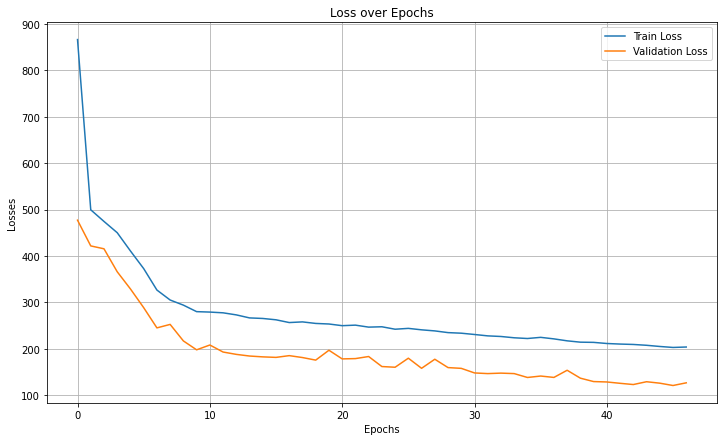

In [47]:
plt.figure(figsize=(12, 7))
plt.title("Loss over Epochs")
plt.plot(losses["train_loss"])
plt.plot(losses["valid_loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend(["Train Loss", "Validation Loss"])
plt.grid("True")
plt.style.use("seaborn-deep")
plt.show()

In [ ]:
  print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 2            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   14935 MB |   14987 MB |   17544 MB |    2608 MB |
|       from large pool |   14932 MB |   14984 MB |   17535 MB |    2603 MB |
|       from small pool |       3 MB |       3 MB |       8 MB |       5 MB |
|---------------------------------------------------------------------------|
| Active memory         |   14935 MB |   14987 MB |   17544 MB |    2608 MB |
|       from large pool |   14932 MB |   14984 MB |   17535 MB |

In [ ]:
import torch
torch.cuda.empty_cache()

In [25]:
best_model = BaselineCNN()
model_name = "baseline_CNN_SGD"
model_path = "/content/drive/MyDrive/DS5500 Data/baselineCNN_best_model_1.pt"
best_model = loadModel(model_path, best_model)
best_model.to(device)

BaselineCNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [32]:
best_model.fc1.weight

Parameter containing:
tensor([[-0.0004, -0.0029, -0.0106,  ..., -0.0094, -0.0062, -0.0046],
        [-0.0074, -0.0081, -0.0016,  ..., -0.0045, -0.0066, -0.0053],
        [-0.0118, -0.0004, -0.0024,  ..., -0.0107, -0.0122,  0.0051],
        ...,
        [-0.0016, -0.0046, -0.0094,  ..., -0.0028, -0.0107, -0.0024],
        [-0.0322,  0.0044, -0.0129,  ..., -0.0104, -0.0207,  0.0194],
        [-0.0258, -0.0116,  0.0162,  ...,  0.0228,  0.0104, -0.0021]],
       device='cuda:0', requires_grad=True)

In [ ]:
# testloader = DataLoader(testset, batch_size=, shuffle=True)
predictions, total_MSE_loss, total_RMSE_loss = model_evaluation(validloader, best_model)
res_df = pd.concat([valid_metadata, predictions], axis=1)
plot_predictions(valid_metadata.wind_speed[0], res_df)
print(total_MSE_loss,total_RMSE_loss)

RuntimeError: ignored

In [ ]:
predictions, total_MSE_loss, total_RMSE_loss = model_evaluation(validloader, best_model, criterion, device)

RuntimeError: ignored

In [ ]:
ts = torch.tensor([[1, 2, 3], [1, 2, 3]])
ts.to(device)

tensor([[1, 2, 3],
        [1, 2, 3]], device='cuda:0')

In [ ]:
ts.cpu()

tensor([[1, 2, 3],
        [1, 2, 3]])

In [ ]:
train_metadata.storm_id.str.split("_")


In [59]:
train_metadata.head()

,image_id,wind_speed,storm_id,relative_time,ocean
0,abs_000,43,abs,0,2
1,abs_001,44,abs,1800,2
2,abs_002,45,abs,5400,2
3,abs_003,52,abs,17999,2
4,abs_004,53,abs,19799,2


In [72]:
def get_data
d = dict()
for i in range(0, train_metadata2.shape[0]):
  i2 = i-9
  i3 = i2-9
  if i3 > 0 and i2 > 0:
    lis = [train_metadata2.image_path[i3], train_metadata2.image_path[i2], train_metadata2.image_path[i]]
    storm_id = train_metadata2.storm_id[i3]
    wind_speed = train_metadata2.wind_speed[i3]

    if storm_id not in d.keys():
      d[storm_id] = {"image_list": [(lis, wind_speed)]}
    else:
      d[storm_id]["image_list"].append((lis, wind_speed))
      # d[storm_id]["wind_speed"].append(wind_speed)


In [74]:
d["abs"]["image_list"][]

(['/content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_abs_003/image.jpg',
  '/content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_abs_013/image.jpg',
  '/content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_abs_027/image.jpg'],
 52)